# M8a: Autoregressive models

In [3]:
# Basic system and data packages
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

## Autoregressive model example for monthly average temperature data

In [5]:
df = pd.read_csv('../../../data/raw/emissions-populations-dvmt.csv')
#Plot the data set
df

# Drop the first column
df = df.drop(columns=['Unnamed: 0'])

# Set the second column as the row index
df = df.set_index('Year')
df

,Mobile GHG Emissions (MMTCO2e),Agriculture GHG Emissions (MMTCO2e),Commercial GHG Emissions (MMTCO2e),Electricity GHG Emissions (MMTCO2e),Industrial GHG Emissions (MMTCO2e),Residential GHG Emissions (MMTCO2e),Solidwaste GHG Emissions (MMTCO2e),Wastewater GHG Emissions (MMTCO2e),Population,DVMT (Miles)
Year,,,,,,,,,,
1990,15.120625,0.375261,3.828568,11.908703,3.001041,8.279021,1.065912,0.359842,3289056,72072000
1991,15.005884,0.348502,3.662331,12.015808,3.100758,8.024783,1.113482,0.361827,3288640,72948000
1992,15.086747,0.389088,4.312955,11.282676,3.355918,9.505435,1.242805,0.362378,3274997,72293000
1993,15.146864,0.415000,3.843474,10.228667,3.447719,9.081525,1.209374,0.363307,3272325,74025000
1994,15.066461,0.408122,4.172272,10.395885,3.150548,8.677775,1.237386,0.365658,3268346,74352000
1995,14.815692,0.400748,3.841800,10.320433,3.103303,7.977389,1.249919,0.365747,3265293,76830000
1996,15.623592,0.344938,4.133427,10.734700,3.257568,8.461561,1.268976,0.367926,3267030,76874000
1997,15.679850,0.348057,4.301810,13.201970,3.266450,8.186120,1.615209,0.368520,3268514,78202000
1998,15.917011,0.375380,4.036593,12.948870,3.119599,7.122707,1.526577,0.371087,3272563,79936000


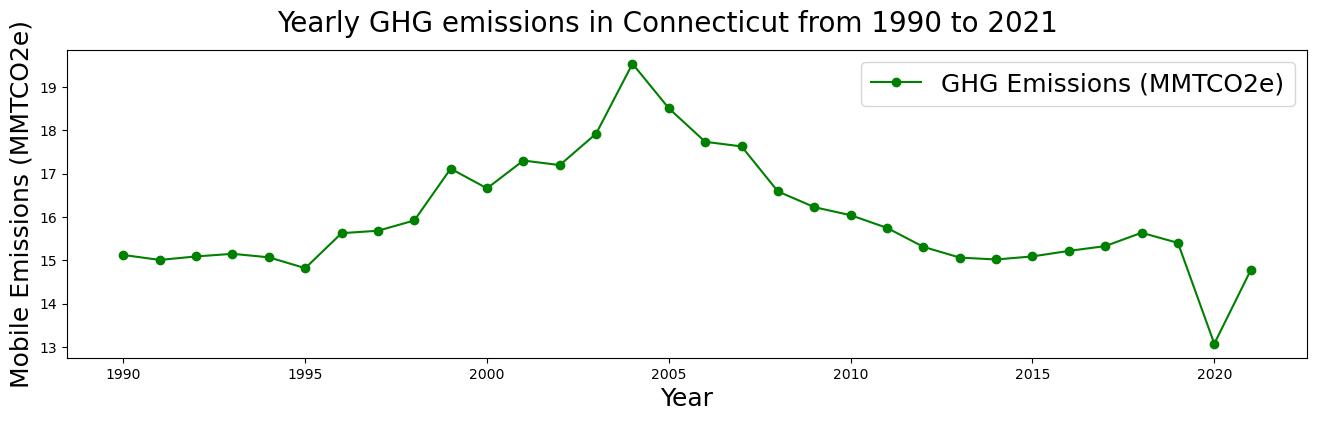

In [29]:
fig = plt.figure(figsize=(16,4))
fig.suptitle('Yearly GHG emissions in Connecticut from 1990 to 2021',fontsize=20)
actual, = plt.plot(df.index, df['Mobile GHG Emissions (MMTCO2e)'], 'go-', label='GHG Emissions (MMTCO2e)')
plt.xlabel('Year',fontsize=18)
plt.ylabel('Mobile Emissions (MMTCO2e)',fontsize=18)
plt.legend(handles=[actual],fontsize=18)
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.show()

In [30]:
#set the date as the index value
# Set 'Column_A' as the row index and add 'Column_B' as a new column
#new_df = df.set_index('Year')[['Mobile GHG Emissions (MMTCO2e)']].copy()
#assigning the training and test set
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()
df_test

,Mobile GHG Emissions (MMTCO2e),Agriculture GHG Emissions (MMTCO2e),Commercial GHG Emissions (MMTCO2e),Electricity GHG Emissions (MMTCO2e),Industrial GHG Emissions (MMTCO2e),Residential GHG Emissions (MMTCO2e),Solidwaste GHG Emissions (MMTCO2e),Wastewater GHG Emissions (MMTCO2e),Population,DVMT (Miles)
Year,,,,,,,,,,
2016,15.214360,0.339883,3.907677,9.289161,3.152446,6.380817,1.950564,0.394595,3579830,86444182
2017,15.325243,0.341291,3.920870,8.501146,3.123419,6.621179,1.868640,0.394567,3575324,86301543
2018,15.633220,0.350344,4.329612,8.066976,3.137983,7.595505,1.766990,0.394951,3574561,86563582
2019,15.399656,0.369979,4.196598,5.690000,3.146549,7.414013,1.860953,0.392797,3566022,86577672
2020,13.071437,0.346028,3.824505,3.200000,3.128899,6.665511,1.842936,0.391845,3597362,81543552
2021,14.766522,0.350000,4.001450,3.040000,3.376378,6.723916,1.850000,0.390000,3623355,79420671


In [31]:
mobile_train = df_train['Mobile GHG Emissions (MMTCO2e)']
mobile_test = df_test['Mobile GHG Emissions (MMTCO2e)']
mod = AutoReg(mobile_train, lags=8, old_names=False)

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
res = mod.fit()

In [33]:
print(res.summary())

                                  AutoReg Model Results                                   
Dep. Variable:     Mobile GHG Emissions (MMTCO2e)   No. Observations:                   26
Model:                                 AutoReg(8)   Log Likelihood                 -10.582
Method:                           Conditional MLE   S.D. of innovations              0.436
Date:                            Fri, 19 Jan 2024   AIC                             41.164
Time:                                    02:50:28   BIC                             50.067
Sample:                                         8   HQIC                            42.391
                                               26                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                10.2646      2.702      3.799  

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


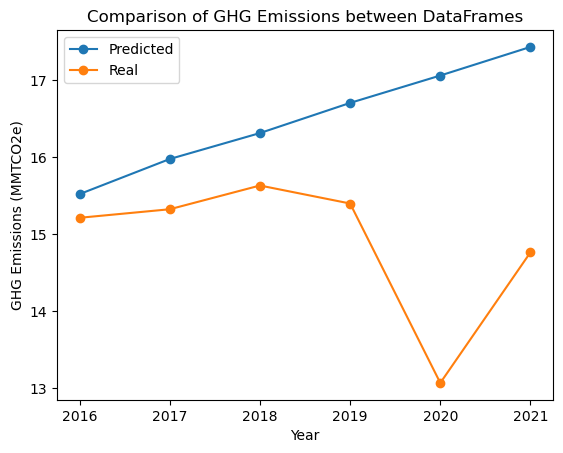

In [34]:
#making predictions on test set and compare

pred=res.predict(start=len(mobile_train),end=len(df)-1,dynamic=False)

# Define a new index
new_index = [2016, 2017, 2018,2019, 2020, 2021]

# Change the index of the Series
#pred = pd.Series(pred.values, index=new_index)

# Convert Series to DataFrame with the first column as the index
predf = pd.DataFrame(list(pred.items()), columns=['Year', 'Mobile GHG Emissions (MMTCO2e)'])
predf['Year']=new_index
#predf['Year'] = pd.to_datetime(predf['Year'], format='%Y')  # Convert the 'Year' column to datetime

# Set the 'Year' column as the index
predf.set_index('Year', inplace=True)

# Plot DataFrame 1
plt.plot(predf.index, predf['Mobile GHG Emissions (MMTCO2e)'], label='Predicted', marker='o')

# Plot DataFrame 2
plt.plot(mobile_test.index, df_test['Mobile GHG Emissions (MMTCO2e)'], label='Real', marker='o')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('GHG Emissions (MMTCO2e)')
plt.title('Comparison of GHG Emissions between DataFrames')
plt.legend()

# Show the plot
plt.show()

In [35]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse=sqrt(mean_squared_error(mobile_test,predf))
rmse
#confidence interval
#without external factor, it will not do well
#plot fitted and predicted
#plot the training model and predicted value and confidence interval, try arima 
#vector autoregression and arima autoregression: need coefficient for : looking at the metric of coefficient
#showing the mean absolute percentage error


2.0697857566724553

In [36]:
#making a future prediction
pred_future=res.predict(start=len(df['Mobile GHG Emissions (MMTCO2e)'])+1,end=len(df['Mobile GHG Emissions (MMTCO2e)'])+7,dynamic=False)
print("the future prediction for the next year")
print(pred_future)
print('Number of predictions Made:\t',len(pred_future))

the future prediction for the next year
33    17.853201
34    17.856924
35    17.665308
36    17.413804
37    17.129459
38    16.774912
39    16.432237
dtype: float64
Number of predictions Made:	 7


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


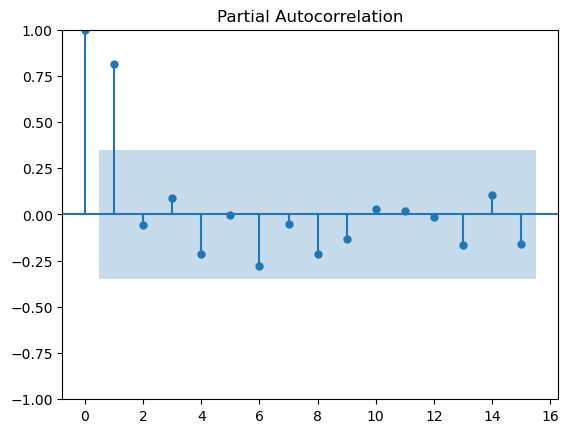

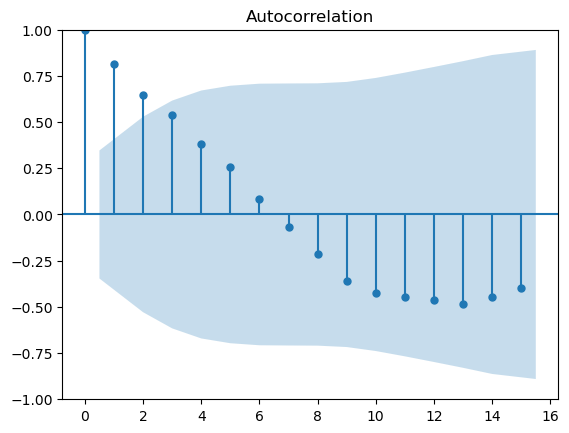

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
pacf=plot_pacf(df['Mobile GHG Emissions (MMTCO2e)'],lags=15)
acf=plot_acf(df['Mobile GHG Emissions (MMTCO2e)'],lags=15)

#high correlation-which lag variable is most relevant 

### Create diagnostic figures based on standardized residuals:
- time series graph
- histogram
- Q-Q plot
- correlogram

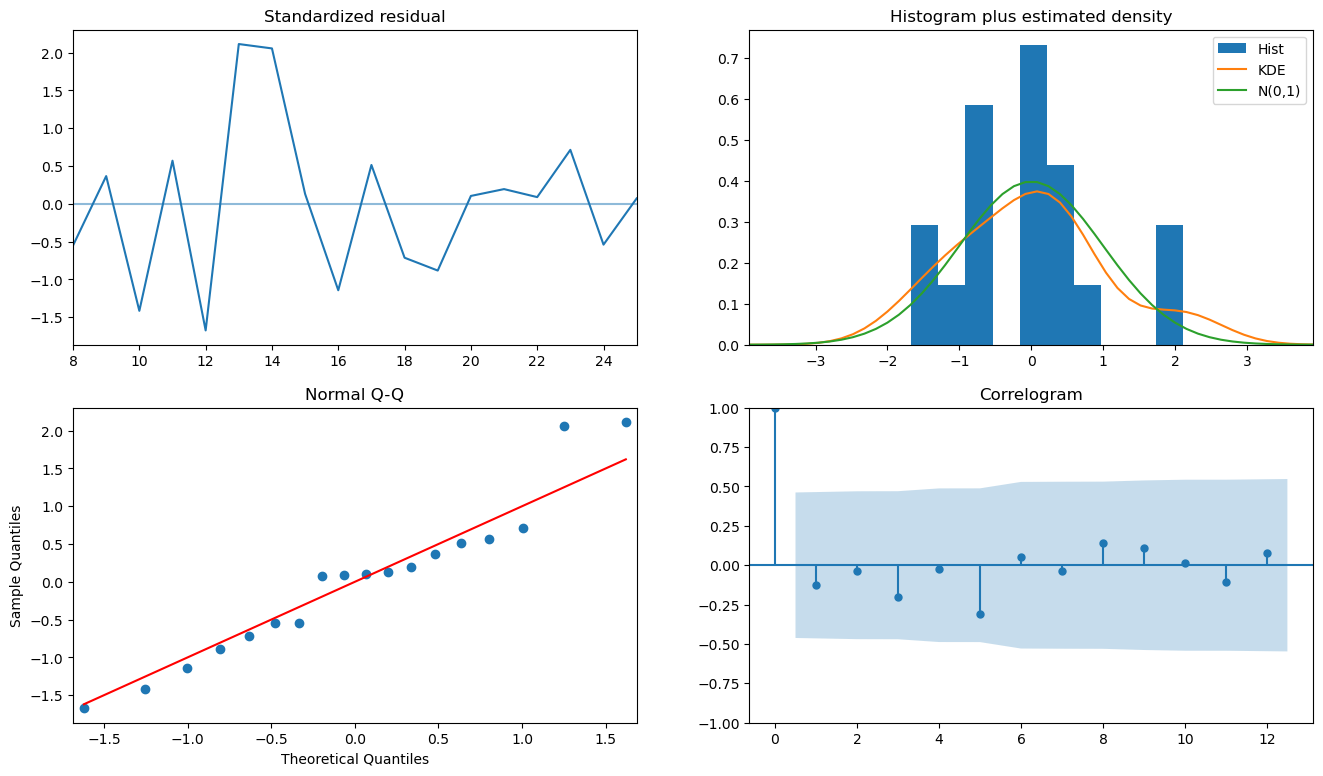

In [38]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=12)

## ARIMA example

In [39]:
exog1 = df_train['DVMT (Miles)']
exog2 = df_train['Population']
# Combine the exogenous variables
exog_combined = pd.concat([exog1, exog2], axis=1)

exog1_test = df_test['DVMT (Miles)']
exog2_test = df_test['Population']
exog_combined_test = pd.concat([exog1_test, exog2_test], axis=1)

# Fit the model
mod = sm.tsa.arima.ARIMA(mobile_train, order=(1,1,0), exog=exog_combined)#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

#increasing the d, the log likelihood decreases
#increasing the q, the log likelihood increases
#increasing the p, the log likelihood does not change

#increasing the q, AIC and BIC increases
#(5,2,0) is the best so far
#increasing p, the p of each coefficient reduces

                                     SARIMAX Results                                      
Dep. Variable:     Mobile GHG Emissions (MMTCO2e)   No. Observations:                   26
Model:                             ARIMA(1, 1, 0)   Log Likelihood                 -21.837
Date:                            Fri, 19 Jan 2024   AIC                             51.674
Time:                                    02:50:29   BIC                             56.550
Sample:                                         0   HQIC                            53.026
                                             - 26                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DVMT (Miles)  1.747e-07   1.33e-07      1.312      0.190   -8.63e-08    4.36e-07
Population   -4.913e-06   9.9

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

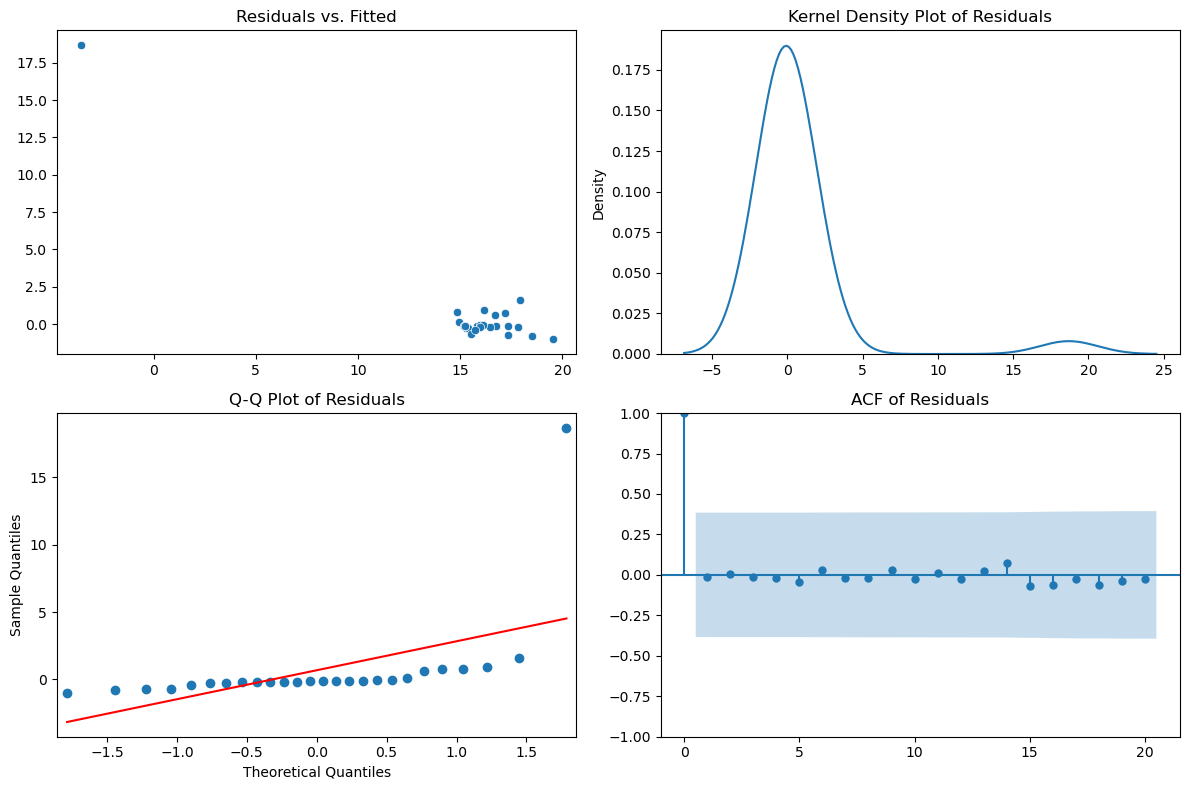

In [40]:
#plot some diagnostics graph 

# Residuals
residuals = res.resid

# Diagnostic Plots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Residuals vs. Fitted values
sns.scatterplot(x=res.fittedvalues, y=residuals, ax=ax[0, 0])
ax[0, 0].set_title('Residuals vs. Fitted')

# Kernel Density Plot of Residuals
sns.kdeplot(residuals, ax=ax[0, 1])
ax[0, 1].set_title('Kernel Density Plot of Residuals')

# Quantile-Quantile (Q-Q) Plot
sm.qqplot(residuals, line='r', ax=ax[1, 0])
ax[1, 0].set_title('Q-Q Plot of Residuals')

# Autocorrelation Function (ACF) of Residuals
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax[1, 1])
ax[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.show()



In [41]:

# Assuming mobile_test is your test data
y_pred_test = res.predict(start=len(mobile_train),end=len(df)-1, exog = exog_combined_test)



C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


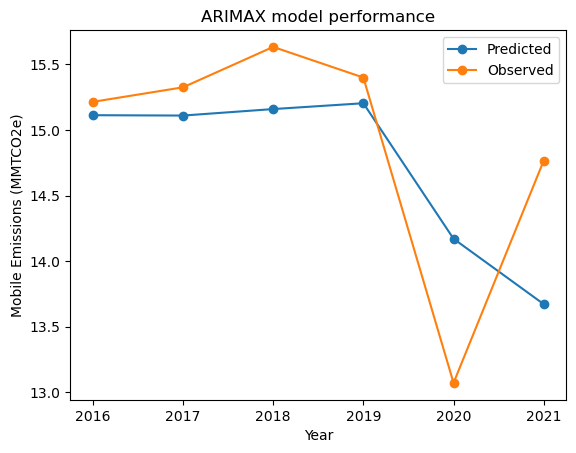

In [42]:
# Define a new index
new_index = [2016, 2017, 2018,2019, 2020, 2021]

# Change the index of the Series
#pred = pd.Series(pred.values, index=new_index)

# Convert Series to DataFrame with the first column as the index
y_pred_test  = pd.DataFrame(list(y_pred_test .items()), columns=['Year', 'Mobile GHG Emissions (MMTCO2e)'])
y_pred_test ['Year']=new_index
#predf['Year'] = pd.to_datetime(predf['Year'], format='%Y')  # Convert the 'Year' column to datetime

# Set the 'Year' column as the index
y_pred_test .set_index('Year', inplace=True)



# Plot DataFrame 1
plt.plot(y_pred_test.index,y_pred_test , label='Predicted', marker='o')

# Plot DataFrame 2
plt.plot(mobile_test.index, mobile_test, label='Observed', marker='o')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Mobile Emissions (MMTCO2e)')
plt.title('ARIMAX model performance')
plt.legend()

# Show the plot
plt.show()